In [1]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math
import copy

In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './final_out'

In [3]:
train_settings = {
    "combined_1": {"epochs": 4, "lr": 0.005, "loss_type": ["distribution", "follow_leader"], 
                                            "factor": [20, [0, 2., 4., 6., 8.]], "alpha": 1.},
}

## Dataloader

In [4]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [5]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [6]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [7]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [8]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

In [9]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train

In [11]:
def train(model, task_num, criterion, prev_model, factor, alpha = 1., epoches = 4, lr = 0.005, loss_type = ["Baseline"]):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), lr)
        
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    distribution_factor = 20
    follow_leader_factor = factor[1][task_num]

    if(task_num != 0):
        leading_factor = follow_leader_factor / task_num * alpha
        if(task_num != 1):
            sub_leading_factor = (follow_leader_factor - leading_factor) / (task_num - 1)
        else:
            sub_leading_factor = 0
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            reg_loss = 0
            if ("distribution" in loss_type):
                random_data = torch.rand(256, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
                fake_output = follower(random_data)
                reg_loss += distribution_factor * criterion(fake_output, random_target)

            if ("follow_leader" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    diff = torch.mean(torch.abs(leader_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]))

                    if (k == task_num - 1): # the nearest model will be the leader
                        reg_loss += leading_factor * diff
                    else:
                        reg_loss += sub_leading_factor * diff
                    
            loss = criterion(outputs[:,:valid_out_dim], labels) + reg_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()
            batch_num += 1

        adjust_learning_rate(optimizer_F)

        avg_acc = 0
        log_message = []
        log_message.append(f"Epoch: {e}, ")
        for task in range(task_num + 1):
            acc = cal_acc(follower, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            log_message.append(f"Task {task} acc: {acc * 100:.4f}")

        logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
    
    return follower, task_accuracies

In [12]:
def setup_logging(file_name):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(file_name),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, loss_type, factor, alpha = settings['epochs'], settings['lr'], settings['loss_type'], settings['factor'], settings['alpha']

    file_name = f"{output_dir}/{task_name}_epochs={epochs}_alpha={alpha}_factor={factor}"

    log_file_name = file_name + '.log'
    img_file_name = file_name + '.png'
    if os.path.exists(log_file_name) == False:
        setup_logging(log_file_name)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            model, task_accuracies = train(model, task, criterion, prev_model, factor = factor, alpha = alpha, 
                                           epoches = epochs, lr = lr, loss_type = loss_type)
            all_accuracies.append(task_accuracies)
            prev_model.append(copy.deepcopy(model))

        plot_task_acc_history(all_accuracies, img_file_name, epochs)

Training on combined_1


2024-06-01 09:54:28,786 - INFO - ##########Task 0##########
2024-06-01 09:54:28,786 - INFO - Epoch 0
2024-06-01 09:54:34,283 - INFO - Epoch: 0, , Task 0 acc: 77.3677, Task avg acc:77.3677
2024-06-01 09:54:34,283 - INFO - Epoch 1
2024-06-01 09:54:39,386 - INFO - Epoch: 1, , Task 0 acc: 96.2213, Task avg acc:96.2213
2024-06-01 09:54:39,387 - INFO - Epoch 2
2024-06-01 09:54:44,656 - INFO - Epoch: 2, , Task 0 acc: 97.4570, Task avg acc:97.4570
2024-06-01 09:54:44,657 - INFO - Epoch 3
2024-06-01 09:54:49,924 - INFO - Epoch: 3, , Task 0 acc: 98.0309, Task avg acc:98.0309
2024-06-01 09:54:49,940 - INFO - ##########Task 1##########
2024-06-01 09:54:49,941 - INFO - Epoch 0
2024-06-01 09:54:57,417 - INFO - Epoch: 0, , Task 0 acc: 68.0724, Task 1 acc: 65.9491, Task avg acc:67.0108
2024-06-01 09:54:57,418 - INFO - Epoch 1
2024-06-01 09:55:04,946 - INFO - Epoch: 1, , Task 0 acc: 73.7883, Task 1 acc: 81.3414, Task avg acc:77.5648
2024-06-01 09:55:04,947 - INFO - Epoch 2
2024-06-01 09:55:13,369 - INF

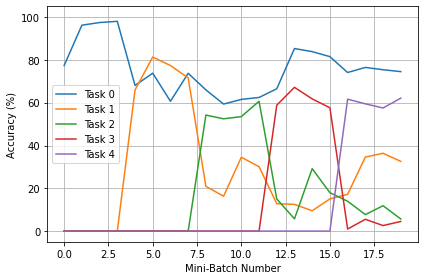

In [13]:
for key in train_settings.keys():
    train_split_task(key)

KeyError: 'l2'

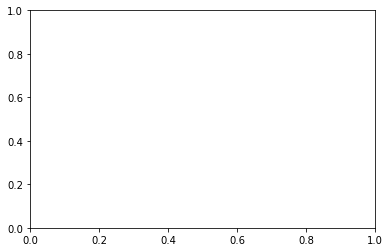

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import math

ncols = 3
nrows = math.ceil(len(train_settings.keys()) / 3.)

plt.figure(figsize=(21, 4 * nrows))  # Adjust the figure size based on the number of rows
for i, key in enumerate(train_settings.keys()):
    plt.subplot(nrows, ncols, i + 1)

    settings = train_settings[key]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']

    file_name = f"{output_dir}/{key}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png"
    try:
        with Image.open(file_name) as img:
            plt.imshow(img)
            plt.title(f"{key}_factor={factor}.png")
            plt.axis('off')
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
plt.tight_layout()
plt.show()  # Move plt.show() outside the loop to display all subplots at once
